In [63]:
import torch
import torch.nn.functional as F

#@torch.jit.script
def ctc_loss(log_probs, targets, input_lengths, target_lengths, blank : int = 0, reduction : str = 'none', alignment : bool = False):
	B = torch.arange(len(targets), device = input_lengths.device)
	print("B,",B)
	print("targets,",targets)
	targets_ = torch.cat([targets, targets[:, :1]], dim = -1)
	print("targets_,",targets_)
	targets_ = torch.stack([torch.full_like(targets_, blank), targets_], dim = -1).flatten(start_dim = -2)
	print("targets_,",targets_)
	print("targets_[:, 2:] != targets_[:, :-2],", targets_[:, 2:] != targets_[:, :-2])
	print("targets_[:, 2:],",targets_[:, 2:])
	print("targets_[:, :-2],",targets_[:, :-2])
	diff_labels = torch.cat([torch.as_tensor([[False, False]], device = targets.device).expand(len(B), -1), targets_[:, 2:] != targets_[:, :-2]], dim = 1)
	print("diff_labels,",diff_labels)
	# if the -inf is used as neutral element, custom logsumexp must be used
	#zero = float('-inf')
	# to avoid nan grad in torch.logsumexp
	zero = torch.finfo(log_probs.dtype).min
	print("zero,",zero)

	zero, zero_padding = torch.tensor(zero, device = log_probs.device, dtype = log_probs.dtype), 2
	print("log_probs,",log_probs)
	log_probs_ = log_probs.gather(-1, targets_.expand(len(log_probs), -1, -1))
	print("targets_.expand(len(log_probs), -1, -1),",targets_.expand(len(log_probs), -1, -1))
	print("log_probs_,",log_probs_)
	log_alpha = torch.full((len(log_probs), len(B), zero_padding + targets_.shape[-1]), zero, device = log_probs.device, dtype = log_probs.dtype)
	log_alpha[0, :, zero_padding + 0] = log_probs[0, :, blank]
	print("log_probs[0, :, blank],",log_probs[0, :, blank])
	log_alpha[0, :, zero_padding + 1] = log_probs[0, B, targets_[:, 1]]
	print("log_alpha.size(),",log_alpha.size())
	print("log_alpha,",log_alpha)
	# log_alpha[1:, :, zero_padding:] = log_probs.gather(-1, targets_.expand(len(log_probs), -1, -1))[1:]
	for t in range(1, len(log_probs)):
		log_alpha[t, :, 2:] = log_probs_[t] + logadd(log_alpha[t - 1, :, 2:], log_alpha[t - 1, :, 1:-1], torch.where(diff_labels, log_alpha[t - 1, :, :-2], zero))
	print("log_alpha,",log_alpha)
	l1l2 = log_alpha[input_lengths - 1, B].gather(-1, torch.stack([zero_padding + target_lengths * 2 - 1, zero_padding + target_lengths * 2], dim = -1)) 
	loss = -torch.logsumexp(l1l2, dim = -1)
	if not alignment:
		return loss
	
	path = torch.zeros(len(log_alpha), len(B), device = log_alpha.device, dtype = torch.int64)
	path[input_lengths - 1, B] = zero_padding + 2 * target_lengths - 1 + l1l2.max(dim = -1).indices
	for t, indices in reversed(list(enumerate(path))[1:]):
		indices_ = torch.stack([(indices - 2) * diff_labels[B, (indices - zero_padding).clamp(min = 0)], (indices - 1).clamp(min = 0), indices], dim = -1)
		path[t - 1] += (indices - 2 + log_alpha[t - 1, B].gather(-1, indices_).max(dim = -1).indices).clamp(min = 0)
	return torch.zeros_like(log_alpha).scatter_(-1, path.unsqueeze(-1), 1.0)[..., (zero_padding + 1)::2]

def ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0, ctc_loss = F.ctc_loss, retain_graph = True):
	loss = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = blank, reduction = 'sum')
	probs = log_probs.exp()
	# to simplify API we inline log_softmax gradient, i.e. next two lines are equivalent to: grad_logits, = torch.autograd.grad(loss, logits, retain_graph = True). gradient formula explained at https://stackoverflow.com/questions/35304393/trying-to-understand-code-that-computes-the-gradient-wrt-to-the-input-for-logsof
	grad_log_probs, = torch.autograd.grad(loss, log_probs, retain_graph = retain_graph)
	grad_logits = grad_log_probs - probs * grad_log_probs.sum(dim = -1, keepdim = True)
	temporal_mask = (torch.arange(len(log_probs), device = input_lengths.device, dtype = input_lengths.dtype).unsqueeze(1) < input_lengths.unsqueeze(0)).unsqueeze(-1)
	return (probs * temporal_mask - grad_logits).detach()

def logadd(x0, x1, x2):
	# produces nan gradients in backward if -inf log-space zero element is used https://github.com/pytorch/pytorch/issues/31829
	return torch.logsumexp(torch.stack([x0, x1, x2]), dim = 0)
	
	# use if -inf log-space zero element is used
	#return LogsumexpFunction.apply(x0, x1, x2)
	
	# produces inplace modification error https://github.com/pytorch/pytorch/issues/31819
	#m = torch.max(torch.max(x0, x1), x2)
	#m = m.masked_fill(torch.isinf(m), 0)
	#res = (x0 - m).exp() + (x1 - m).exp() + (x2 - m).exp()
	#return res.log().add(m)

class LogsumexpFunction(torch.autograd.function.Function):
	@staticmethod
	def forward(self, x0, x1, x2):
		m = torch.max(torch.max(x0, x1), x2)
		m = m.masked_fill_(torch.isinf(m), 0)
		e0 = (x0 - m).exp_()
		e1 = (x1 - m).exp_()
		e2 = (x2 - m).exp_()
		e = (e0 + e1 + e2).clamp_(min = 1e-16)
		self.save_for_backward(e0, e1, e2, e)
		return e.log().add_(m)

	@staticmethod
	def backward(self, grad_output):
		e0, e1, e2, e = self.saved_tensors
		g = grad_output / e
		return g * e0, g * e1, g * e2


log_probs tensor([[[-2.94, -1.06, -1.49, -2.87, -3.51, -1.90, -1.99]],

        [[-3.59, -1.03, -1.59, -2.52, -1.33, -4.84, -2.86]],

        [[-1.79, -0.96, -1.96, -2.73, -2.17, -2.74, -2.77]],

        [[-2.31, -1.09, -4.42, -1.47, -1.62, -3.15, -2.52]],

        [[-0.86, -1.69, -6.59, -2.31, -2.36, -1.67, -4.73]],

        [[-2.25, -1.32, -2.11, -1.07, -2.07, -3.58, -4.68]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)
Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.0008490085601806641 bwd 0.0008418560028076172
B, tensor([0], device='cuda:0')
targets, tensor([[1, 2, 3]], device='cuda:0')
targets_, tensor([[1, 2, 3, 1]], device='cuda:0')
targets_, tensor([[0, 1, 0, 2, 0, 3, 0, 1]], device='cuda:0')
targets_[:, 2:] != targets_[:, :-2], tensor([[False,  True, False,  True, False,  True]], device='cuda:0')
targets_[:, 2:], tensor([[0, 2, 0, 3, 0, 1]], device='cuda:0')
targets_[:, :-2], tensor([[0, 1, 0, 2, 0, 3]], devi

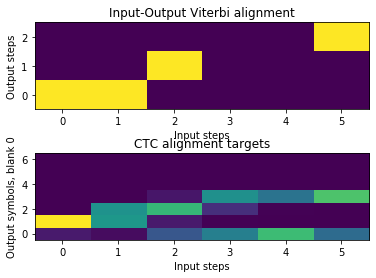

In [64]:
# test abc-3

probs_seq1 = [[
            0.06390443, 0.42124858, 0.27323887, 0.06870235, 0.0361254,
            0.18184413, 0.16493624
        ], [
            0.03309247, 0.42866108, 0.24390638, 0.09699597, 0.31895462,
            0.0094893, 0.06890021
        ], [
            0.218104, 0.49992557, 0.18245131, 0.08503348, 0.14903535,
            0.08424043, 0.08120984
        ], [
            0.12094152, 0.41162472, 0.01473646, 0.28045061, 0.24246305,
            0.05206269, 0.09772094
        ], [
            0.9333387, 0.40550838, 0.00301669, 0.21745861, 0.20803985,
            0.41317442, 0.01946335
        ], [
            0.16468227, 0.4180699, 0.1906545, 0.53963251, 0.19860937,
            0.04377724, 0.01457421
        ]]
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
torch.set_printoptions(precision=2)


# import ctc

T, B, C = 6, 1, 7
t = 3
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([1,2,3]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)
print("log_probs",log_probs)
print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
# print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
# print(a.t().cpu())
# print(targets[:,0])
# print(logits)



In [29]:
print(targets, targets[:, :1])

tensor([[1, 2, 3]], device='cuda:0') tensor([[1]], device='cuda:0')


In [53]:
t = torch.tensor([[1,2],[3,4]])
r = torch.gather(t, 1, torch.tensor([[0,0],[1,0]]))
index = [[0,0],[1,0]]
i,j,k = 0,0,1
print(t[index[j][k]][k] )

tensor(2)


In [54]:
print(r)

tensor([[1, 1],
        [4, 3]])


In [55]:
t.gather(1, torch.tensor([[0,0],[1,0]]))

tensor([[1, 1],
        [4, 3]])

In [56]:
t.gather(-1, torch.tensor([[0,0],[1,0]]))

tensor([[1, 1],
        [4, 3]])